# Perform analysis of performance for the models

In [3]:
import os
import matplotlib.pyplot as plt


# for font embeddings
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)
res_dir = "results"
os.makedirs(res_dir, exist_ok=True)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams["font.family"] = "serif"
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### dataset managers

In [2]:
import torch
from utils import get_datasets, get_models, get_title_mappings


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# load in the datasets
CSM, datasets = get_datasets(device=device)
CDM = CSM.get_scene_dataset_by_index(0)
pc_test = CDM.get_lidar(
    frame=CDM.get_frames("lidar-0", 0)[0], sensor="lidar-0", agent=0
)

# load in the models
models = get_models(
    device=device, cfg_names=["unet_adversarial", "unet_mc_adversarial"]
)
model_titles, adv_titles = get_title_mappings()

# set up paths for saving
CDM = CSM.get_scene_dataset_by_index(0)
pc_test = CDM.get_lidar(
    frame=CDM.get_frames("lidar-0", 0)[0], sensor="lidar-0", agent=0
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/unet_adversarial/model_20240911_170545/epoch_8.pth
A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models
loading model weights from ../../scripts/segmentation_training/unet_mc_adversarial/model_20240911_171628/epoch_9.pth


### Run evaluation

In [6]:
from tqdm import tqdm
import pickle
from collections import defaultdict
from fov.train import BinarySegmentation


# preset the dataset dictionary
results = defaultdict(list)

# loop over data elements
n_frames_max = 200
for dataset_name, dataset in datasets.items():
    print(f"Running over {dataset_name} dataset...")
    n_frames_run = min(n_frames_max, len(dataset))
    for i, data in tqdm(enumerate(dataset), total=n_frames_run):
        if i > n_frames_run:
            break
        else:
            # get data
            pc_img, gt_mask = data
            pc_img = torch.unsqueeze(pc_img, 0)
            pc_np = dataset.get_pointcloud(i)
            metadata = dataset.get_metadata(i)

            # loop over the models
            for model_name, model in models.items():
                # inference
                pc_img_pred = model(pc_img, pc_np, metadata)

                # metrics
                metrics = BinarySegmentation.metrics(
                    outputs=pc_img_pred,
                    labels=gt_mask,
                    loss_fn=None,
                    threshold=0.7,
                    pos_weight=1.0,
                    neg_weight=1.0,
                    run_auprc=True,
                )

                # add the results to the logger
                results["dataset"].append(dataset_name)
                results["adv_model"].append(metadata["adv_model"])
                results["n_pts_adv"].append(metadata["n_pts_adv"])
                results["frame"].append(metadata["frame"])
                results["sensor"].append(metadata["sensor"])
                results["agent"].append(metadata["agent"])
                results["model"].append(model_name)

                # add pretty results specifically for plotting
                results["Adversary Model"].append(adv_titles[metadata["adv_model"]])
                results["Model Name"].append(model_titles[model_name])

                # add quantitative metrics
                for k, v in metrics.items():
                    if v is not None:
                        try:
                            try:
                                res = v.detach().cpu().item()
                            except ValueError:
                                res = v.detach().cpu()
                            results[k].append(res)
                        except AttributeError:
                            results[k].append(v)

# save the metrics
with open(os.path.join("results", "last_metrics.p"), "wb") as f:
    pickle.dump(results, f)

Running over benign dataset...


  0%|          | 0/200 [00:00<?, ?it/s]

201it [00:45,  4.43it/s]                         


Running over adversarial dataset...


201it [00:39,  5.09it/s]                         


### Analyze results

In [4]:
import os
import pandas as pd
import seaborn as sns
import pickle


# load in the resuls
met_path = os.path.join(res_dir, "last_metrics.p")
if os.path.exists(met_path):
    with open(met_path, "rb") as f:
        results = pickle.load(f)

# get the full dataframe
df_results = pd.DataFrame.from_dict(results)
print(df_results.shape)
df_results.head()

# perform some mappings on columns to avoid reprocessing everything
model_name_mods = {
    "Quantized Ray Trace": "Quant. Ray Trace",
    "Continuous Ray Trace": "Cont. Ray Trace",
    "Concave Hull Polygon": "Concave Hull",
    "MLE UNet + Adv-Train": "MLE UNet +\nAdv-Train",
    "MCD UNet + Adv-Train": "MCD UNet +\nAdv-Train",
}
df_results["Model Name"] = df_results["Model Name"].apply(
    lambda x: model_name_mods.get(x, x)
)
df_results["Adversary Model"] = df_results["Adversary Model"].apply(
    lambda x: x.replace(" Attack", "")
)

(2010, 18)


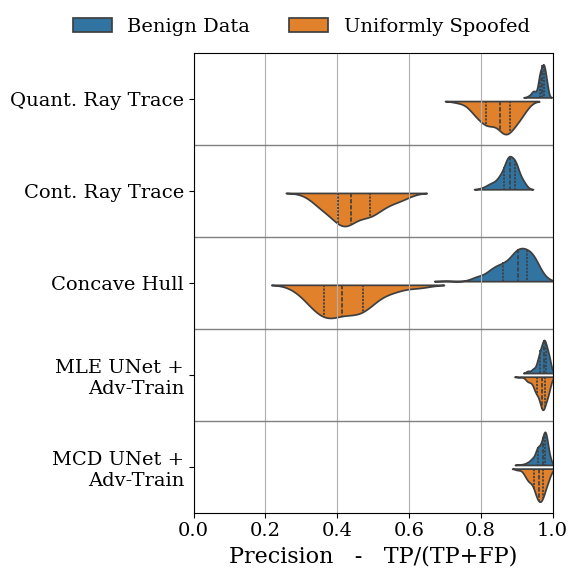

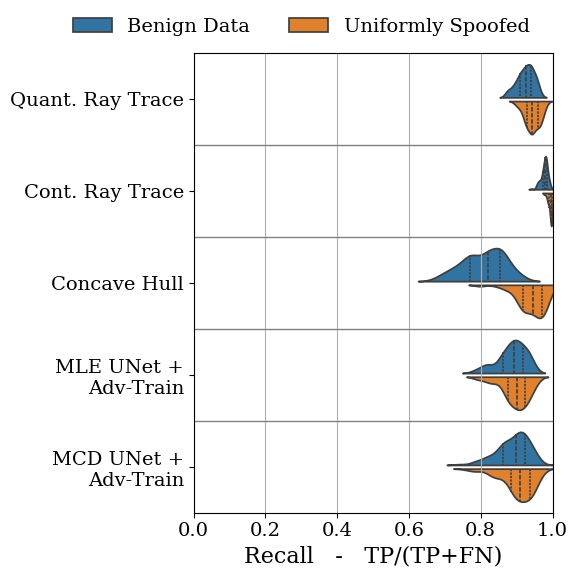

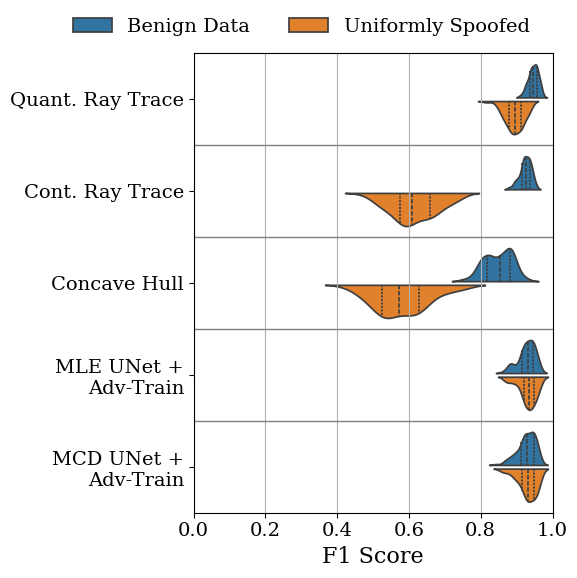

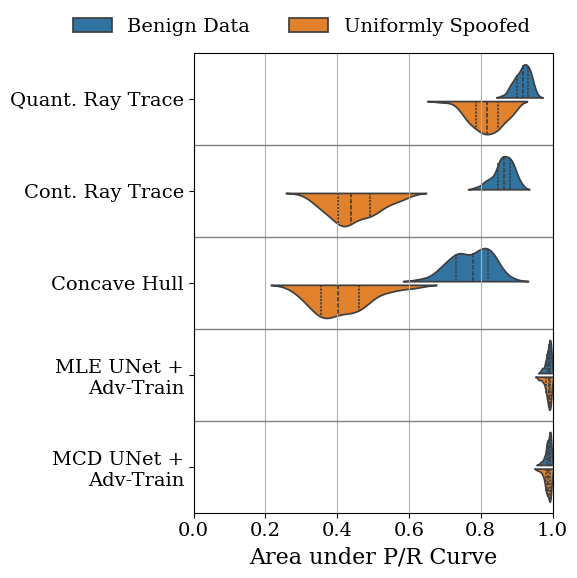

In [5]:
# violin plot of some of the performance metrics for different attacks
import numpy as np

save_dir = os.path.join(fig_dir, "violin")
os.makedirs(save_dir, exist_ok=True)

metrics_violin = ["precision", "recall", "f1", "auprc"]
metric_name_xlabel = {
    "precision": "Precision   -   TP/(TP+FP)",
    "recall": "Recall   -   TP/(TP+FN)",
    "f1": "F1 Score",
    "auprc": "Area under P/R Curve",
}

# --- make a plot for each of the metrics
for metric in metrics_violin:
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # downsample the results columns
    df_res_sample = df_results.loc[df_results["adv_model"] != "cluster"]

    # make the plot
    g1 = sns.violinplot(
        data=df_res_sample,
        x=metric,
        y="Model Name",
        hue="Adversary Model",
        split=True,
        inner="quart",
        gap=0.1,
        fill=True,
        legend="brief",
        dodge=True,
        log_scale=False,
        density_norm="count",
        ax=ax,
    )
    g1.set(ylabel=None, xlabel=metric_name_xlabel[metric])
    g1.set_xlim(left=0.0, right=1.0)
    ax.grid(axis="x")

    # move the legend
    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(0.3, 1),
        ncol=3,
        title=None,
        frameon=False,
    )

    # add separating lines between models
    for i in range(len(np.unique(df_results["Model Name"])) - 1):
        ax.axhline(i + 0.5, color="grey", lw=1)

    # save the plot
    plt.tight_layout()
    save_path = os.path.join(save_dir, "violin_{}.{}".format(metric, "{}"))
    plt.savefig(save_path.format("png"))
    plt.savefig(save_path.format("pdf"))